In [1]:
#tensorflow 버전 확인
import tensorflow as tf
print(tf.__version__)

2.6.0


In [2]:
# device list에 GPU있나 확인
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13775553318343400611
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7799308288
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15449367781023354635
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:01:00.0, compute capability: 8.6"
]


In [3]:
#라이브러리 설치
!pip install transformers
!pip install keras==2.6

!pip install scikit-learn

#필요한 모듈 불러오기
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertForSequenceClassification

from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd

from tabulate import tabulate
from tqdm import trange
import random
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')


print("GPU available:",torch.cuda.is_available())

GPU available: True


In [15]:
# 내 깃허브 폴더에서 리뷰 데이터 불러와서 dataframe으로 저장
# Price 속성 리뷰
url='https://raw.githubusercontent.com/Eunjin3395/graduation_project/main/data/ambience_total.csv'
df = pd.read_csv(url,sep=',', header=0, encoding_errors='ignore')
df.head(5)

,id,text,category,polarity
0,1779,The owner and staff are all Japanese as well a...,ambience,1
1,35171678#484493#2,"everything is scrumptious, from the excellent ...",ambience,1
2,2851,It's like you are transported to the Italian c...,ambience,1
3,838,The aesthetics of this place are like an airpo...,ambience,0
4,en_CatalRestaurant__UvaBar_477861893:3,It was romantic - and even nice even with my s...,ambience,1


In [16]:
df.tail(5)

,id,text,category,polarity
560,Z#6:3,"If you?셱e planning to come here, make sure tha...",ambience,1
561,2146,"The staff makes you feel at home, the food is ...",ambience,1
562,3367,"Best of all is the warm vibe, the owner is sup...",ambience,1
563,en_ParkChaletGardenRestaurant_477778171:11,Sunday afternoons there is a band playing and ...,ambience,1
564,1901,"Great vibe, lots of people.",ambience,1


In [17]:
df.dtypes

id          object
text        object
category    object
polarity     int64
dtype: object

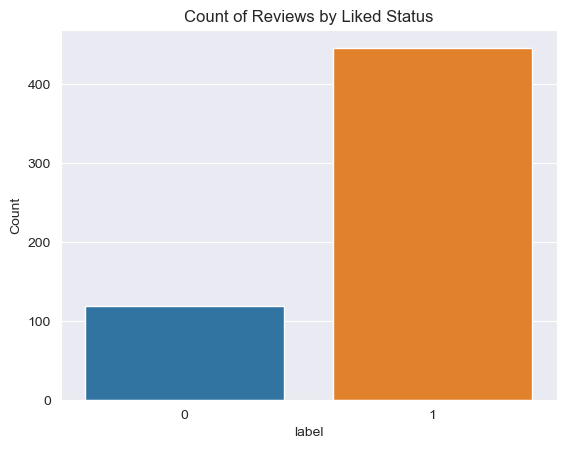

In [18]:
# review data의 label 분포
sns.set_style('darkgrid')

# Create a count plot of the "Liked" column
sns.countplot(x='polarity', data=df)

# Set the title of the plot
plt.title('Count of Reviews by Liked Status')

# Set the label for the x-axis
plt.xlabel('label')

# Set the label for the y-axis
plt.ylabel('Count')

# Show the plot
plt.show()

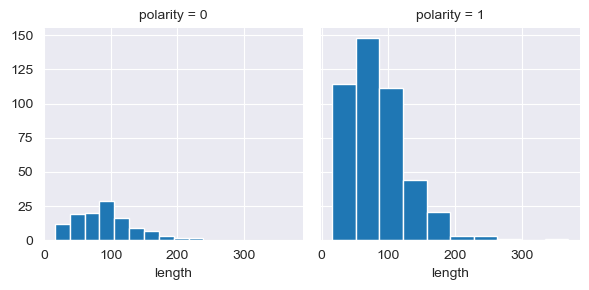

In [19]:
# review data의 길이 분포 및 통계
df_new=df
df_new['length'] = df['text'].apply(len)

# Create a FacetGrid object with 'Liked' as the column to be used for separating the data
# FacetGrid is a grid of subplots that displays the same relationship between different subsets of your data.
g = sns.FacetGrid(df, col='polarity')

# Use the FacetGrid object to plot a histogram of the 'Length' column for each value of 'Liked'
g.map(plt.hist, 'length');

In [20]:
df_new.length.describe()

count    565.000000
mean      86.423009
std       44.969412
min       16.000000
25%       53.000000
50%       80.000000
75%      110.000000
max      370.000000
Name: length, dtype: float64

In [21]:
text = df.text.values
labels = df.polarity.values

In [22]:
# 전처리
tokenizer = BertTokenizer.from_pretrained(
    'bert-base-uncased',
    do_lower_case = True
    )

In [23]:
MAX_LENGTH=370
token_id = []
attention_masks = []

def preprocessing(input_text, tokenizer):
  '''
  Returns <class transformers.tokenization_utils_base.BatchEncoding> with the following fields:
    - input_ids: list of token ids
    - token_type_ids: list of token type ids
    - attention_mask: list of indices (0,1) specifying which tokens should considered by the model (return_attention_mask = True).
  '''
  return tokenizer.encode_plus(
                        input_text,
                        add_special_tokens = True,
                        max_length = MAX_LENGTH,
                        pad_to_max_length = True,
                        return_attention_mask = True,
                        return_tensors = 'pt',
                        truncation=True
                   )


for sample in text:
  encoding_dict = preprocessing(sample, tokenizer)

  # token_id 리스트 추출
  token_id.append(encoding_dict['input_ids']) 
  # attention_mask 리스트 추출
  attention_masks.append(encoding_dict['attention_mask'])


# 리스트를 텐서로
token_id = torch.cat(token_id, dim = 0)
attention_masks = torch.cat(attention_masks, dim = 0)
labels = torch.tensor(labels)

In [24]:
VAL_RATIO= 0.2
batch_size = 8 # 16 or 32 추천이라고 한다

# Indices of the train and validation splits stratified by labels
train_idx, val_idx = train_test_split(
    np.arange(len(labels)),
    test_size = VAL_RATIO,
    shuffle = True,
    stratify = labels)

# Train and validation sets
train_set = TensorDataset(token_id[train_idx], 
                          attention_masks[train_idx], 
                          labels[train_idx])

val_set = TensorDataset(token_id[val_idx], 
                        attention_masks[val_idx], 
                        labels[val_idx])

# Prepare DataLoader
train_dataloader = DataLoader(
            train_set,
            sampler = RandomSampler(train_set),
            batch_size = batch_size
        )

validation_dataloader = DataLoader(
            val_set,
            sampler = SequentialSampler(val_set),
            batch_size = batch_size
        )


print("train: {}".format(len(train_idx)))
print("validation: {}".format(len(val_idx)))


train: 452
validation: 113


In [25]:

def b_tp(preds, labels):
  '''Returns True Positives (TP): count of correct predictions of actual class 1'''
  return sum([preds == labels and preds == 1 for preds, labels in zip(preds, labels)])

def b_fp(preds, labels):
  '''Returns False Positives (FP): count of wrong predictions of actual class 1'''
  return sum([preds != labels and preds == 1 for preds, labels in zip(preds, labels)])

def b_tn(preds, labels):
  '''Returns True Negatives (TN): count of correct predictions of actual class 0'''
  return sum([preds == labels and preds == 0 for preds, labels in zip(preds, labels)])

def b_fn(preds, labels):
  '''Returns False Negatives (FN): count of wrong predictions of actual class 0'''
  return sum([preds != labels and preds == 0 for preds, labels in zip(preds, labels)])

def b_metrics(preds, labels):
  '''
  Returns the following metrics:
    - accuracy    = (TP + TN) / N
    - precision   = TP / (TP + FP)
    - recall      = TP / (TP + FN)
    - specificity = TN / (TN + FP)
  '''
  preds = np.argmax(preds, axis = 1).flatten()
  labels = labels.flatten()
  tp = b_tp(preds, labels)
  tn = b_tn(preds, labels)
  fp = b_fp(preds, labels)
  fn = b_fn(preds, labels)
  b_accuracy = (tp + tn) / len(labels)
  b_precision = tp / (tp + fp) if (tp + fp) > 0 else 'nan'
  b_recall = tp / (tp + fn) if (tp + fn) > 0 else 'nan'
  b_specificity = tn / (tn + fp) if (tn + fp) > 0 else 'nan'
  return b_accuracy, b_precision, b_recall, b_specificity

In [26]:
# BERT 모델 불러오기
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels = 2,
    output_attentions = False,
    output_hidden_states = False,
)


optimizer = torch.optim.AdamW(model.parameters(), 
                              lr = 5e-5, # learning rate 설정
                              eps = 1e-08
                              )

model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [27]:
# GPU로 학습하도록 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 학습 횟수 설정
epochs = 10

idx=0
epo_list=[]
train_loss_list=[]
val_accuracy_list=[]

for _ in trange(epochs, desc = 'Epoch'):
    idx+=1
    epo_list.append(idx)

    # ========== Training ==========
    model.train()
    
    # Tracking variables
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0

    for step, batch in enumerate(train_dataloader):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        optimizer.zero_grad()
        # Forward pass
        train_output = model(b_input_ids, 
                             token_type_ids = None, 
                             attention_mask = b_input_mask, 
                             labels = b_labels)
        # Backward pass
        train_output.loss.backward()
        optimizer.step()
        # Update tracking variables
        tr_loss += train_output.loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1

    # ========== Validation ==========
    model.eval()

    # Tracking variables 
    val_accuracy = []
    val_precision = []
    val_recall = []
    val_specificity = []

    for batch in validation_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        with torch.no_grad():
          # Forward pass
          eval_output = model(b_input_ids, 
                              token_type_ids = None, 
                              attention_mask = b_input_mask)
        logits = eval_output.logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        # Calculate validation metrics
        b_accuracy, b_precision, b_recall, b_specificity = b_metrics(logits, label_ids)
        val_accuracy.append(b_accuracy)
        # Update precision only when (tp + fp) !=0; ignore nan
        if b_precision != 'nan': val_precision.append(b_precision)
        # Update recall only when (tp + fn) !=0; ignore nan
        if b_recall != 'nan': val_recall.append(b_recall)
        # Update specificity only when (tn + fp) !=0; ignore nan
        if b_specificity != 'nan': val_specificity.append(b_specificity)

    print('\n\t - Train loss: {:.4f}'.format(tr_loss / nb_tr_steps))
    print('\t - Validation Accuracy: {:.4f}'.format(sum(val_accuracy)/len(val_accuracy)))
    val_accuracy_temp=sum(val_accuracy)/len(val_accuracy)
    train_loss_list.append(round(tr_loss / nb_tr_steps,4))
    val_accuracy_list.append(round(val_accuracy_temp,4))
    #print('\t - Validation Precision: {:.4f}'.format(sum(val_precision)/len(val_precision)) if len(val_precision)>0 else '\t - Validation Precision: NaN')
    #print('\t - Validation Recall: {:.4f}'.format(sum(val_recall)/len(val_recall)) if len(val_recall)>0 else '\t - Validation Recall: NaN')
    #print('\t - Validation Specificity: {:.4f}\n'.format(sum(val_specificity)/len(val_specificity)) if len(val_specificity)>0 else '\t - Validation Specificity: NaN')


Epoch:  10%|███████▌                                                                    | 1/10 [00:12<01:56, 12.89s/it]


	 - Train loss: 0.4327
	 - Validation Accuracy: 0.9583


Epoch:  20%|███████████████▏                                                            | 2/10 [00:22<01:26, 10.81s/it]


	 - Train loss: 0.1697
	 - Validation Accuracy: 0.9000


Epoch:  30%|██████████████████████▊                                                     | 3/10 [00:31<01:11, 10.18s/it]


	 - Train loss: 0.1178
	 - Validation Accuracy: 0.9333


Epoch:  40%|██████████████████████████████▍                                             | 4/10 [00:41<00:59,  9.86s/it]


	 - Train loss: 0.0349
	 - Validation Accuracy: 0.9250


Epoch:  50%|██████████████████████████████████████                                      | 5/10 [00:50<00:48,  9.72s/it]


	 - Train loss: 0.0029
	 - Validation Accuracy: 0.9417


Epoch:  60%|█████████████████████████████████████████████▌                              | 6/10 [01:00<00:38,  9.64s/it]


	 - Train loss: 0.0008
	 - Validation Accuracy: 0.9417


Epoch:  70%|█████████████████████████████████████████████████████▏                      | 7/10 [01:09<00:28,  9.58s/it]


	 - Train loss: 0.0006
	 - Validation Accuracy: 0.9417


Epoch:  80%|████████████████████████████████████████████████████████████▊               | 8/10 [01:18<00:19,  9.54s/it]


	 - Train loss: 0.0263
	 - Validation Accuracy: 0.9417


Epoch:  90%|████████████████████████████████████████████████████████████████████▍       | 9/10 [01:28<00:09,  9.52s/it]


	 - Train loss: 0.0122
	 - Validation Accuracy: 0.9167


Epoch: 100%|███████████████████████████████████████████████████████████████████████████| 10/10 [01:37<00:00,  9.78s/it]


	 - Train loss: 0.0005
	 - Validation Accuracy: 0.9083


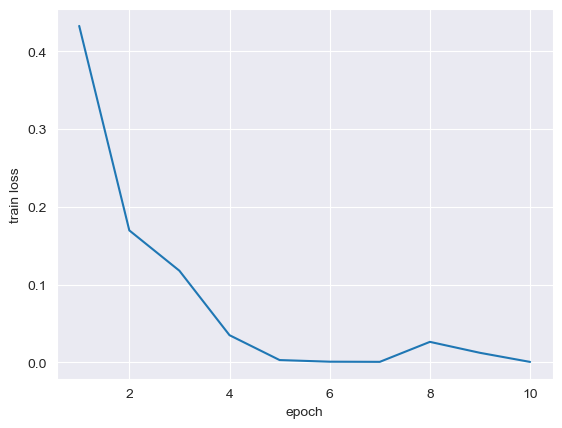

In [28]:
# train loss 그래프
plt.plot(epo_list, train_loss_list)
plt.xlabel('epoch')
plt.ylabel('train loss')
plt.show()

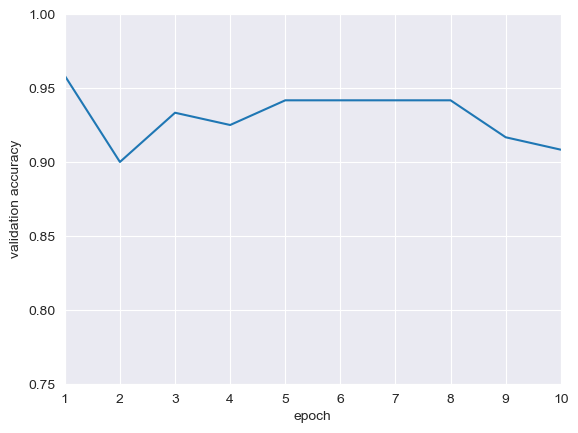

In [29]:
plt.plot(epo_list, val_accuracy_list)
plt.xlabel('epoch')
plt.ylabel('validation accuracy')
plt.axis([1,epochs , 0.75, 1])
plt.show()

In [30]:
#새로운 리뷰를 분류해보자

def test_sentence(sentence):
    # 토큰 ID와 attention mask를 위한 리스트
    test_ids = []
    test_attention_mask = []

    # 전처리
    encoding = preprocessing(sentence, tokenizer)
    test_ids.append(encoding['input_ids'])
    test_attention_mask.append(encoding['attention_mask'])
    test_ids = torch.cat(test_ids, dim = 0)
    test_attention_mask = torch.cat(test_attention_mask, dim = 0)
    
    # Forward pass, calculate logit predictions
    with torch.no_grad():
        output = model(test_ids.to(device), token_type_ids = None, attention_mask = test_attention_mask.to(device))

    prediction = 'Positive' if np.argmax(output.logits.cpu().numpy()).flatten().item() == 1 else 'Negative'
    return prediction
    

    
    
new_sentence ='Not reasonable price, but goot atmosphere'
# 'It''s good, but the owner is so unkind. Some of the plates didn''t clean properly because there was something on them. But it''s cost-effective.'





print('입력 문장:', new_sentence)
print('분류:', test_sentence(new_sentence))

입력 문장: Not reasonable price, but goot atmosphere
분류: Positive


In [31]:
#test data 세팅

# 내 깃허브 폴더에서 리뷰 데이터 불러와서 dataframe으로 저장
test_url='https://raw.githubusercontent.com/Eunjin3395/graduation_project/main/data/ambience_test.csv'
df = pd.read_csv(test_url,sep=',', header=0, encoding_errors='ignore')
df.head(5)

,id,text,category,polarity
0,35177381#521555#0,"I came to fresh expecting a great meal, and al...",ambience,0
1,11302357#835238#2,"The ambiance was pretty cool, but not worth th...",ambience,0
2,11302356#1455624#1,"The food is top notch, the service is attentiv...",ambience,1
3,32892130#435512#0,If you're craving some serious indian food and...,ambience,1
4,11359619#487952#3,it is a hidden delight complete with a quaint ...,ambience,1


In [32]:
count=0

test_text = df.text.values
test_labels = df.polarity.values

for i in range(len(test_labels)):
    t = df.iloc[i].text
    color_s='\033[31m' 
    color_e='\033[0m'
    
    prediction=test_sentence(t)
    if(prediction=="Negative"):
        result=0
    else:
        result=1
        
    if(result==df.iloc[i].polarity):
        count+=1     
        color_s=''
        color_e=''
    print(color_s+"=============================== Input {} ===============================".format(i+1))
    print(t)
    print("model result:",prediction,"\nanswer:", df.iloc[i].polarity,color_e)
    print("")


print("test accuracy: {:.4f}".format(count/len(test_labels)))
    

=============================== Input 1 ===============================
I came to fresh expecting a great meal, and all I got was marginally so-so food served in a restaurant that was just so freezing we couldn't enjoy eating.
model result: Negative 
answer: 0 

=============================== Input 2 ===============================
The ambiance was pretty cool, but not worth the hassle.
model result: Positive 
answer: 0 

=============================== Input 3 ===============================
The food is top notch, the service is attentive, and the atmosphere is great.
model result: Positive 
answer: 1 

=============================== Input 4 ===============================
If you're craving some serious indian food and desire a cozy ambiance, this is quite and exquisite choice.
model result: Positive 
answer: 1 

=============================== Input 5 ===============================
it is a hidden delight complete with a quaint bar and good food.
model result: Positive 
answer: 1 
